# A. Modelling

## Dependencies

In [251]:
# cadCAD standard dependencies

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

# cadCAD global simulation configuration list
from cadCAD import configs

# Included with cadCAD
import pandas as pd

In [366]:
import random

import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

## 1. State Variables

In [336]:
initial_state = {
    "AMM": {"A1": 1000, "A2": 1000, "s": 100},
    "Trader": {"A1": 100, "A2": 100, "s": 0},
    "LP": {"A1": 0, "A2": 0, "s": 100},
    "timestep": [0],
    
    "agent": " ",
    "token": " ",
    "value": 0,
    "share": 0,
    "price":  1,
    'fee': {"A1": 0, "A2": 0}
}

## 2. System Parameters

In [337]:
system_params = {"fee": [0.05], 
                 "chance_liquidity" : [0.1], 
                 "chance_A1" : [0.5]}

## 3. Policy Functions

In [338]:
'''
The function determines the action that 
will be executed in the system: 
Trade or Liquidity add/removal
'''

def p_action(system_params, substep, state_history, previous_state):

    weights = [system_params["chance_liquidity"], 1-system_params["chance_liquidity"]]
    strings = ["Liquidity", "Trader"]
    agent = random.choices(strings, weights=weights)[0]
    
    token = "A1"
    value = 0
    share = 0
    
    # If agent is Trader --> the action is a trade
    if agent == "Trader":
        
        weights = [system_params["chance_A1"], 1-system_params["chance_A1"]]
        strings = ["A1", "A2"]
        token = random.choices(strings, weights=weights)[0]
        
        if token == "A1":
            value = random.uniform(0, previous_state["Trader"]["A2"])
        elif token == "A2": 
            value = random.uniform(0, previous_state["Trader"]["A1"])
    
    # If agent is Liquidity --> the action is liquidity provision/removal
    elif agent == 'Liquidity':
        
        share = random.uniform(-0.4, 0.4)
        
    return {"agent": agent, "value": value, "share": share, 'token': token}

In [339]:
'''
The function determines conditions
ot the Trade
'''

def p_swapToAsset(system_params, substep, state_history, previous_state):
    
    timestep =  previous_state["timestep"]
    
    # Parameters
    feeFactor = (1-system_params["fee"])
    
    # State Variables
    agent = previous_state['agent']
    token = previous_state['token']
    value = previous_state['value']
    
    AMM_A1 = previous_state["AMM"]["A1"]
    AMM_A2 = previous_state["AMM"]["A2"]
    Trader_A1 = previous_state["Trader"]["A1"]
    Trader_A2 = previous_state["Trader"]["A2"]
    
    # In this case we buy "A1" for "A2"
    if agent == 'Trader' and token == 'A1':
        dA2 = value
        dA1 = AMM_A1/(AMM_A2+dA2*feeFactor)*dA2*feeFactor
        
        if dA2 < Trader_A2:
            return {"add_to_Trader_A1": dA1 , "add_to_AMM_A1": -dA1, 
                        "add_to_Trader_A2": -dA2, "add_to_AMM_A2": dA2} 
    
    # In this case we buy "A2" for "A1"
    if agent == 'Trader' and token == 'A2':
        dA1 = value
        dA2 = AMM_A2/(AMM_A1+dA1*feeFactor)*dA1*feeFactor
        
        if dA1 < Trader_A1:
            return {"add_to_Trader_A1": -dA1 , "add_to_AMM_A1": dA1, 
                        "add_to_Trader_A2": dA2, "add_to_AMM_A2": -dA2}
    
    
    # Return an empty dictionary if no conditions were met
    return {"add_to_Trader_A1": 0 , "add_to_AMM_A1": 0, 
                    "add_to_Trader_A2": 0, "add_to_AMM_A2": 0}


In [340]:
'''
The function determines conditions
ot the Liquidity add/removal
'''

def p_Liquidity(system_params, substep, state_history, previous_state):
    
    timestep =  previous_state["timestep"]
    
    # State Variables
    agent = previous_state['agent']
    share = previous_state['share']
    
    AMM_A1 = previous_state["AMM"]["A1"]
    AMM_A2 = previous_state["AMM"]["A2"]
    AMM_s =  previous_state["AMM"]["s"]
    
    LP_A1 = previous_state["LP"]["A1"]
    LP_A2 = previous_state["LP"]["A2"]
    LP_s = previous_state["LP"]["s"]
    
    # In case LP adds/removes liquidity from the pool
    if agent == 'Liquidity':
        
        dA1 = AMM_A1 * share
        dA2 = AMM_A2 * share
        add_s = AMM_s * share
    
        if (dA1 < 0 and dA2 < 0 and (AMM_A1 - dA1) > 0 and (AMM_A2 - dA2) > 0 ) or (
            dA1 > 0 and dA2 > 0 and (LP_A1 - dA1) > 0 and (LP_A2 - dA2) > 0):

            return {"add_to_AMM_A1": dA1 , "add_to_LP_A1": -dA1, "add_to_LP_s": add_s,
                        "add_to_AMM_A2": dA2, "add_to_LP_A2": -dA2, "add_to_AMM_s": add_s }
    
    return {"add_to_AMM_A1": 0 , "add_to_LP_A1": 0, "add_to_LP_s": 0,
                        "add_to_AMM_A2": 0, "add_to_LP_A2": 0, "add_to_AMM_s": 0 }

## 4. State Update Functions

In [341]:
'''
- The State Update Functions is the cell allow to 
randomize action between Trading and Liquidity provision/removal
on each timestep
- The functions are executed in the first subset
after execution of functions other blocks are updated
based on executions of these functions
'''

def s_price(system_params, substep, state_history, previous_state, policy_input):
    
    updated_price = previous_state['AMM']['A2'] / previous_state['AMM']['A1'] 

    return "price", updated_price


def s_agent(system_params, substep, state_history, previous_state, policy_input):
    
    updated_agent = policy_input['agent']

    return "agent", updated_agent


def s_token(system_params, substep, state_history, previous_state, policy_input):
    
    updated_token = policy_input['token']

    return "token", updated_token

def s_share(system_params, substep, state_history, previous_state, policy_input):
    
    updated_share = policy_input['share']

    return "share", updated_share

def s_timestep(system_params, substep, state_history, previous_state, policy_input):
    
    updated_timestep = previous_state["timestep"] + 1

    return "timestep", updated_timestep

In [342]:
'''
The function updates collected fees 
on each timestep
'''

def s_fee(system_params, substep, state_history, previous_state, policy_input):
    
    fee_A1 = previous_state['fee']['A1']
    fee_A2 = previous_state['fee']['A2']
    
    collected_fee_A1 = 0
    collected_fee_A2 = 0
    
    if previous_state["token"] == "A1" and previous_state["agent"] == "Trader":
        collected_fee_A2 = previous_state["value"] * system_params['fee']
        
    elif previous_state["token"] == "A2" and previous_state["agent"] == "Trader":
        collected_fee_A1 = previous_state["value"] * system_params['fee']

    return "fee", {"A1": fee_A1 + collected_fee_A1  , "A2": fee_A2 + collected_fee_A2}

In [343]:
'''
The function updates the AMM state
on each timestep
'''

def s_AMM(system_params, substep, state_history, previous_state, policy_input):
    
    add_to_AMM_A1 = policy_input['add_to_AMM_A1']
    add_to_AMM_A2 = policy_input['add_to_AMM_A2']
    add_to_AMM_s = policy_input['add_to_AMM_s']
    
    
    # State Variables
    AMM_A1 = previous_state["AMM"]["A1"]
    AMM_A2 = previous_state["AMM"]["A2"]
    AMM_s =  previous_state["AMM"]["s"]
    

    # Calculate updated states
    updated_AMM_A1 = AMM_A1 + add_to_AMM_A1
    updated_AMM_A2 = AMM_A2 + add_to_AMM_A2
    updated_AMM_s = AMM_s + add_to_AMM_s
    

    return "AMM", {"A1":updated_AMM_A1,"A2":updated_AMM_A2,"s":updated_AMM_s}


In [344]:
'''
The function updates the Trader balance state
on each timestep
'''

def s_Trader(system_params, substep, state_history, previous_state, policy_input):
    
    add_to_Trader_A1 = policy_input['add_to_Trader_A1']
    add_to_Trader_A2 = policy_input['add_to_Trader_A2']
    
    
    # State Variables
    Trader_A1 = previous_state["Trader"]["A1"]
    Trader_A2 = previous_state["Trader"]["A2"]
    

    # Calculate updated states
    updated_Trader_A1 = Trader_A1 + add_to_Trader_A1
    updated_Trader_A2 = Trader_A2 + add_to_Trader_A2
    

    return "Trader", {"A1":updated_Trader_A1,"A2":updated_Trader_A2,"s":100}

In [345]:
'''
The function updates the LP balance state
on each timestep
'''

def s_LP(system_params, substep, state_history, previous_state, policy_input):
    
    add_to_LP_A1 = policy_input['add_to_LP_A1']
    add_to_LP_A2 = policy_input['add_to_LP_A2']
    add_to_LP_s = policy_input['add_to_LP_s']
    
    
    # State Variables
    LP_A1 = previous_state["LP"]["A1"]
    LP_A2 = previous_state["LP"]["A2"]
    LP_s =  previous_state["LP"]["s"]
    

    # Calculate updated states
    updated_LP_A1 = LP_A1 + add_to_LP_A1
    updated_LP_A2 = LP_A2 + add_to_LP_A2
    updated_LP_s = LP_s + add_to_LP_s
    

    return "LP", {"A1":updated_LP_A1,"A2":updated_LP_A2,"s":updated_LP_s}

## 5. Partial State Update Blocks

# B. Simulation

In [346]:
'''
1) Firstly, we execute functions that determine which 
action will be performed in the system: 
Trade (then determine its conditions) 
or Liquidity (add/removal) 
2) Secondly, we execute the action that was determined
in the previous step
3) Thirdly, we calculate the price in the pool 
after the action
'''
partial_state_update_blocks = [
    {
        'policies': {
            'p_action': p_action
        },
        'variables': {
            'agent': s_agent,
            'token': s_token,
            'share': s_share,
            'value': s_value
        }
    },
    {
        'policies': {
            'Swaps': p_swapToAsset,
            'Liquidity': p_Liquidity
        },
        'variables': {
            'AMM': s_AMM,
            'timestep': s_timestep,
            'Trader': s_Trader,
            'LP': s_LP,
            'fee': s_fee
        }
    },
    {
        'policies': {},
        'variables': {
            'price': s_price,
        }
    },
]


## 6. Configuration

In [347]:
sim_config = config_sim({
    "N": 1, # the number of times we'll run the simulation ("Monte Carlo runs")
    "T": range(100), # the number of timesteps the simulation will run for
    "M": system_params # the parameters of the system
})

In [348]:
del configs[:] # Clear any prior configs

In [349]:
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

## 7. Execution

In [350]:
exec_context = ExecutionContext()
simulation = Executor(exec_context=exec_context, configs=experiment.configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 3, 1, 10)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 3, 1, 10)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.10s


In [351]:
# Convert raw results to a Pandas DataFrame
df = pd.DataFrame(raw_result)

df

,AMM,Trader,LP,timestep,agent,token,value,share,price,fee,simulation,subset,run,substep
0,"{'A1': 1000, 'A2': 1000, 's': 100}","{'A1': 100, 'A2': 100, 's': 0}","{'A1': 0, 'A2': 0, 's': 100}",0,,,0.000000,0.0,1.000000,"{'A1': 0, 'A2': 0}",0,0,1,0
1,"{'A1': 1000, 'A2': 1000, 's': 100}","{'A1': 100, 'A2': 100, 's': 0}","{'A1': 0, 'A2': 0, 's': 100}",1,Trader,A1,93.280068,0.0,1.000000,"{'A1': 0, 'A2': 0}",0,0,1,1
2,"{'A1': 918.5975038788874, 'A2': 1093.280068430...","{'A1': 181.4024961211125, 'A2': 6.719931569157...","{'A1': 0, 'A2': 0, 's': 100}",1,Trader,A1,93.280068,0.0,1.000000,"{'A1': 0, 'A2': 4.664003421542123}",0,0,1,2
3,"{'A1': 918.5975038788874, 'A2': 1093.280068430...","{'A1': 181.4024961211125, 'A2': 6.719931569157...","{'A1': 0, 'A2': 0, 's': 100}",1,Trader,A1,93.280068,0.0,1.190162,"{'A1': 0, 'A2': 4.664003421542123}",0,0,1,3
4,"{'A1': 918.5975038788874, 'A2': 1093.280068430...","{'A1': 181.4024961211125, 'A2': 6.719931569157...","{'A1': 0, 'A2': 0, 's': 100}",2,Trader,A2,37.191529,0.0,1.190162,"{'A1': 0, 'A2': 4.664003421542123}",0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,"{'A1': 522.423415854516, 'A2': 531.14873206121...","{'A1': 21.267760915768818, 'A2': 59.1342275765...","{'A1': 556.3088232297152, 'A2': 509.7170403622...",99,Trader,A2,41.891968,0.0,1.196879,"{'A1': 58.31991341272282, 'A2': 64.42061980842...",0,0,1,2
297,"{'A1': 522.423415854516, 'A2': 531.14873206121...","{'A1': 21.267760915768818, 'A2': 59.1342275765...","{'A1': 556.3088232297152, 'A2': 509.7170403622...",99,Trader,A2,41.891968,0.0,1.016702,"{'A1': 58.31991341272282, 'A2': 64.42061980842...",0,0,1,3
298,"{'A1': 522.423415854516, 'A2': 531.14873206121...","{'A1': 21.267760915768818, 'A2': 59.1342275765...","{'A1': 556.3088232297152, 'A2': 509.7170403622...",100,Trader,A1,27.132086,0.0,1.016702,"{'A1': 58.31991341272282, 'A2': 64.42061980842...",0,0,1,1
299,"{'A1': 498.24469457458554, 'A2': 558.280818364...","{'A1': 45.44648219569922, 'A2': 32.00214127319...","{'A1': 556.3088232297152, 'A2': 509.7170403622...",100,Trader,A1,27.132086,0.0,1.016702,"{'A1': 58.31991341272282, 'A2': 65.77722412358...",0,0,1,2


# C. Analysis

### 1. Initial_state_1 (starting price is 1)

In [377]:
initial_state = {
    "AMM": {"A1": 1000, "A2": 1000, "s": 100},
    "Trader": {"A1": 100, "A2": 100, "s": 0},
    "LP": {"A1": 0, "A2": 0, "s": 100},
    "timestep": [0],
    
    "agent": " ",
    "token": " ",
    "value": 0,
    "share": 0,
    "price":  1,
    'fee': {"A1": 0, "A2": 0}
}

In [378]:
del configs[:] # Clear any prior configs

In [379]:
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

In [380]:
exec_context = ExecutionContext()
simulation = Executor(exec_context=exec_context, configs=experiment.configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 3, 1, 10)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 3, 1, 10)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.05s


In [381]:
# Convert raw results to a Pandas DataFrame
df = pd.DataFrame(raw_result)

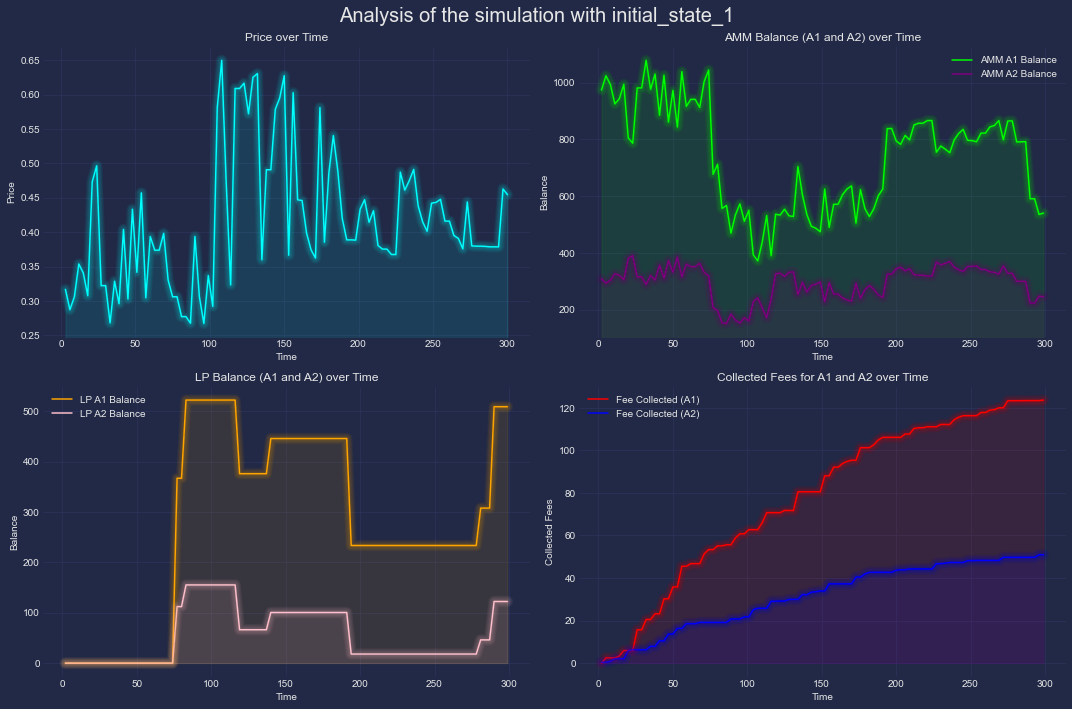

In [401]:
# Style with cyberpunk
plt.style.use("cyberpunk")


# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Analysis of the simulation with initial_state_1', fontsize=20)

# Filter data
df_price = df[df['substep'] == 3]
df_amm_lp_fee = df[df['substep'] == 2]

# Plotting the "price" data
sns.lineplot(x=df_price.index, y=df_price["price"], ax=axs[0, 0], color='cyan')
mplcyberpunk.add_glow_effects(axs[0, 0])
# Adding labels and title to the plot
axs[0, 0].set(xlabel="Time", ylabel="Price", title="Price over Time")

# Extracting the 'A1' and 'A2' balance values from the 'AMM' column
amm_balance_A1 = df_amm_lp_fee['AMM'].apply(lambda x: x['A1'])
amm_balance_A2 = df_amm_lp_fee['AMM'].apply(lambda x: x['A2'])
# Plotting the AMM balance of A1 and A2 over time
sns.lineplot(x=df_amm_lp_fee.index, y=amm_balance_A1, ax=axs[0, 1], label='AMM A1 Balance', color='lime')
sns.lineplot(x=df_amm_lp_fee.index, y=amm_balance_A2, ax=axs[0, 1], label='AMM A2 Balance', color='purple')
mplcyberpunk.add_glow_effects(axs[0, 1])
# Adding labels and a title to the plot
axs[0, 1].set(xlabel='Time', ylabel='Balance', title='AMM Balance (A1 and A2) over Time')
# Adding a legend
# axs[0, 1].legend()

# Extracting the LP balance values for A1 and A2 tokens from the 'LP' column
lp_balance_A1 = df_amm_lp_fee['LP'].apply(lambda x: x['A1'])
lp_balance_A2 = df_amm_lp_fee['LP'].apply(lambda x: x['A2'])
# Plotting the LP balance of A1 and A2 over time
sns.lineplot(x=df_amm_lp_fee.index, y=lp_balance_A1, ax=axs[1, 0], label='LP A1 Balance', color='orange')
sns.lineplot(x=df_amm_lp_fee.index, y=lp_balance_A2, ax=axs[1, 0], label='LP A2 Balance', color='pink')
mplcyberpunk.add_glow_effects(axs[1, 0])
# Adding labels and a title to the plot
axs[1, 0].set(xlabel='Time', ylabel='Balance', title='LP Balance (A1 and A2) over Time')
# Adding a legend
# axs[1, 0].legend()

# Extracting the fee values for A1 and A2 tokens from the 'fee' column
fee_A1 = [entry['A1'] for entry in df_amm_lp_fee['fee']]
fee_A2 = [entry['A2'] for entry in df_amm_lp_fee['fee']]
# Plotting the fees collected for A1 and A2 over time
sns.lineplot(x=df_amm_lp_fee.index, y=fee_A1, ax=axs[1, 1], label='Fee Collected (A1)', color='red')
sns.lineplot(x=df_amm_lp_fee.index, y=fee_A2, ax=axs[1, 1], label='Fee Collected (A2)', color='blue')
mplcyberpunk.add_glow_effects(axs[1, 1])
# Adding labels and a title to the plot
axs[1, 1].set(xlabel='Time', ylabel='Collected Fees', title='Collected Fees for A1 and A2 over Time')
# Adding a legend
# axs[1, 1].legend()

# Auto layout of the plot
plt.tight_layout()
# Displaying the plots
plt.show()


### 1. Initial_state_2 (starting price is 0.3)

In [402]:
initial_state = {
    "AMM": {"A1": 1000, "A2": 300, "s": 100},
    "Trader": {"A1": 100, "A2": 100, "s": 0},
    "LP": {"A1": 0, "A2": 0, "s": 100},
    "timestep": [0],
    
    "agent": " ",
    "token": " ",
    "value": 0,
    "share": 0,
    "price":  1,
    'fee': {"A1": 0, "A2": 0}
}

In [403]:
del configs[:] # Clear any prior configs

In [404]:
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

In [405]:
exec_context = ExecutionContext()
simulation = Executor(exec_context=exec_context, configs=experiment.configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 3, 1, 10)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 3, 1, 10)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.09s


In [406]:
# Convert raw results to a Pandas DataFrame
df = pd.DataFrame(raw_result)

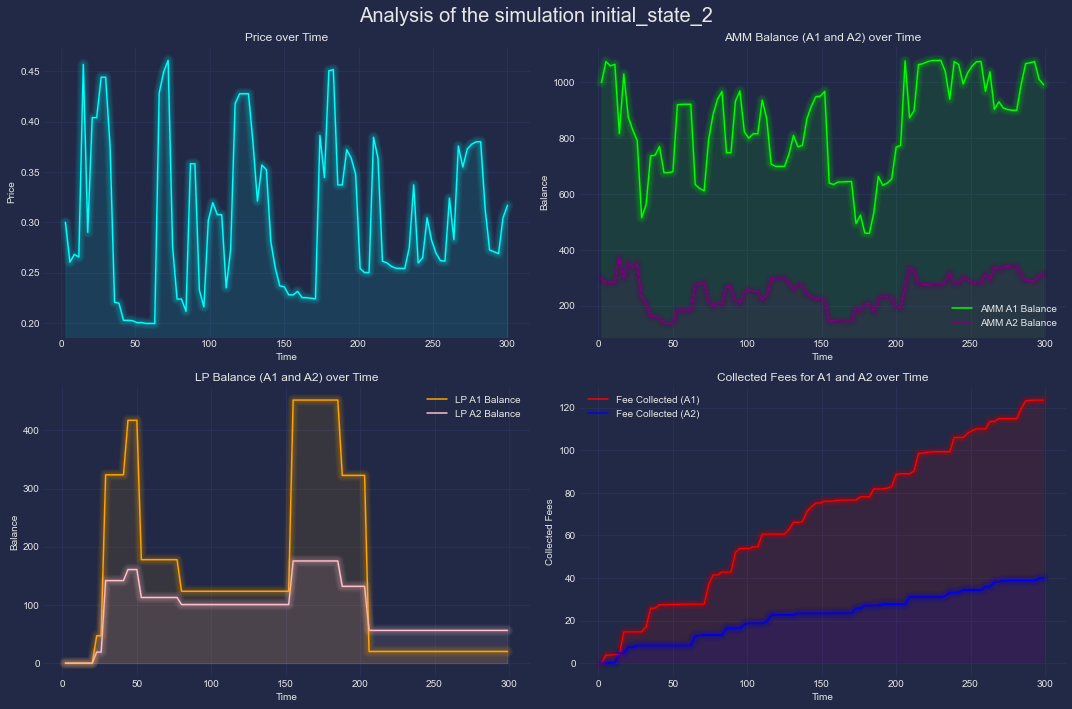

In [407]:
# Style with cyberpunk
plt.style.use("cyberpunk")


# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Analysis of the simulation initial_state_2', fontsize=20)

# Filter data
df_price = df[df['substep'] == 3]
df_amm_lp_fee = df[df['substep'] == 2]

# Plotting the "price" data
sns.lineplot(x=df_price.index, y=df_price["price"], ax=axs[0, 0], color='cyan')
mplcyberpunk.add_glow_effects(axs[0, 0])
# Adding labels and title to the plot
axs[0, 0].set(xlabel="Time", ylabel="Price", title="Price over Time")

# Extracting the 'A1' and 'A2' balance values from the 'AMM' column
amm_balance_A1 = df_amm_lp_fee['AMM'].apply(lambda x: x['A1'])
amm_balance_A2 = df_amm_lp_fee['AMM'].apply(lambda x: x['A2'])
# Plotting the AMM balance of A1 and A2 over time
sns.lineplot(x=df_amm_lp_fee.index, y=amm_balance_A1, ax=axs[0, 1], label='AMM A1 Balance', color='lime')
sns.lineplot(x=df_amm_lp_fee.index, y=amm_balance_A2, ax=axs[0, 1], label='AMM A2 Balance', color='purple')
mplcyberpunk.add_glow_effects(axs[0, 1])
# Adding labels and a title to the plot
axs[0, 1].set(xlabel='Time', ylabel='Balance', title='AMM Balance (A1 and A2) over Time')
# Adding a legend
# axs[0, 1].legend()

# Extracting the LP balance values for A1 and A2 tokens from the 'LP' column
lp_balance_A1 = df_amm_lp_fee['LP'].apply(lambda x: x['A1'])
lp_balance_A2 = df_amm_lp_fee['LP'].apply(lambda x: x['A2'])
# Plotting the LP balance of A1 and A2 over time
sns.lineplot(x=df_amm_lp_fee.index, y=lp_balance_A1, ax=axs[1, 0], label='LP A1 Balance', color='orange')
sns.lineplot(x=df_amm_lp_fee.index, y=lp_balance_A2, ax=axs[1, 0], label='LP A2 Balance', color='pink')
mplcyberpunk.add_glow_effects(axs[1, 0])
# Adding labels and a title to the plot
axs[1, 0].set(xlabel='Time', ylabel='Balance', title='LP Balance (A1 and A2) over Time')
# Adding a legend
# axs[1, 0].legend()

# Extracting the fee values for A1 and A2 tokens from the 'fee' column
fee_A1 = [entry['A1'] for entry in df_amm_lp_fee['fee']]
fee_A2 = [entry['A2'] for entry in df_amm_lp_fee['fee']]
# Plotting the fees collected for A1 and A2 over time
sns.lineplot(x=df_amm_lp_fee.index, y=fee_A1, ax=axs[1, 1], label='Fee Collected (A1)', color='red')
sns.lineplot(x=df_amm_lp_fee.index, y=fee_A2, ax=axs[1, 1], label='Fee Collected (A2)', color='blue')
mplcyberpunk.add_glow_effects(axs[1, 1])
# Adding labels and a title to the plot
axs[1, 1].set(xlabel='Time', ylabel='Collected Fees', title='Collected Fees for A1 and A2 over Time')
# Adding a legend
# axs[1, 1].legend()

# Auto layout of the plot
plt.tight_layout()
# Displaying the plots
plt.show()
